In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
import numpy as np



As for now, I plan to experiment with the entire pipeline in this notebook. As for later, more computationally heavy parts can be writte to .py files for integration with the dashboard. 

**LOAD THE DATA**

In [4]:
df_b = pd.read_parquet('../data/processed/burglaries.parquet')
df_burglaries = df_b.groupby(['Ward code', 'Month']).size().reset_index(name='Crime count')
print(df_burglaries.columns)
display(df_burglaries.head())

df_c = pd.read_parquet('../data/processed/census_lsoa.parquet')
df_census = df_c.groupby('Ward code').sum(numeric_only=True).reset_index() # sum of LSOAs in each ward
print(df_census.columns)
display(df_census.head())

df_d = pd.read_parquet('../data/processed/deprivation_lsoa.parquet')
df_deprivation = df_d.groupby('Ward code').mean(numeric_only=True).reset_index() # average of LSOAs in each ward
print(df_deprivation.columns)
display(df_deprivation)

# boundary data
gdf_ward_boundaries = gpd.read_file('../data/boundaries/ward boundaries 2024/london_wards_merged.shp')


Index(['Ward code', 'Month', 'Crime count'], dtype='object')


,Ward code,Month,Crime count
0,E05009317,2022-04-01,8
1,E05009317,2022-05-01,17
2,E05009317,2022-06-01,7
3,E05009317,2022-07-01,10
4,E05009317,2022-08-01,10


Index(['Ward code', 'Total population', 'Under 15 years', '15 to 64 years',
       '65 years and older', 'Total: All households', 'One-person household',
       'One-person household: Aged 66 years and over',
       'One-person household: Other', 'Single family household',
       'Other household types', 'Detached whole house or bungalow',
       'Semi-detached whole house or bungalow',
       'Terraced whole house or bungalow', 'Flat, maisonette or apartment',
       'A caravan or other mobile or temporary structure',
       'Total: All dwellings', 'Total: Occupied dwellings',
       'Unoccupied dwellings'],
      dtype='object')


,Ward code,Total population,Under 15 years,15 to 64 years,65 years and older,Total: All households,One-person household,One-person household: Aged 66 years and over,One-person household: Other,Single family household,Other household types,Detached whole house or bungalow,Semi-detached whole house or bungalow,Terraced whole house or bungalow,"Flat, maisonette or apartment",A caravan or other mobile or temporary structure,Total: All dwellings,Total: Occupied dwellings,Unoccupied dwellings
0,E05009317,23708,4456,17884,1368,8044.0,2260.0,454.0,1806.0,4283.0,1501.0,60.0,130.0,870.0,7410.0,0.0,8535,8030,490.0
1,E05009318,21615,3325,17514,776,9571.0,3491.0,245.0,3246.0,4708.0,1372.0,0.0,75.0,335.0,10925.0,80.0,11490,9545,1945.0
2,E05009319,19540,3228,15150,1162,8401.0,2721.0,492.0,2229.0,4398.0,1282.0,115.0,205.0,935.0,7700.0,0.0,8990,8405,580.0
3,E05009320,13708,2396,10173,1139,5277.0,1529.0,406.0,1123.0,2656.0,1092.0,50.0,165.0,1360.0,3980.0,0.0,5580,5275,305.0
4,E05009321,11567,2401,8465,701,4441.0,1418.0,208.0,1210.0,2326.0,697.0,45.0,105.0,350.0,4180.0,20.0,4725,4445,280.0


Index(['Ward code', 'Index of Multiple Deprivation (IMD) Score',
       'Index of Multiple Deprivation (IMD) Rank',
       'Index of Multiple Deprivation (IMD) Decile', 'Income Score',
       'Income Rank', 'Income Decile', 'Employment Score', 'Employment Rank',
       'Employment Decile', 'Education, Skills and Training Score',
       'Education, Skills and Training Rank',
       'Education, Skills and Training Decile',
       'Health Deprivation and Disability Score',
       'Health Deprivation and Disability Rank',
       'Health Deprivation and Disability Decile', 'Crime Score', 'Crime Rank',
       'Crime Decile', 'Barriers to Housing and Services Score',
       'Barriers to Housing and Services Rank',
       'Barriers to Housing and Services Decile', 'Living Environment Score',
       'Living Environment Rank', 'Living Environment Decile'],
      dtype='object')


,Ward code,Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile,Income Score,Income Rank,Income Decile,Employment Score,Employment Rank,Employment Decile,...,Health Deprivation and Disability Decile,Crime Score,Crime Rank,Crime Decile,Barriers to Housing and Services Score,Barriers to Housing and Services Rank,Barriers to Housing and Services Decile,Living Environment Score,Living Environment Rank,Living Environment Decile
0,E05009317,29.618149,8591.484596,3.216929,0.202229,7069.749127,2.800262,0.111058,12027.812847,4.100524,...,4.300262,0.667665,8068.050580,3.150786,29.623605,7349.157218,2.616405,36.876296,6322.995315,2.449738
1,E05009318,18.023071,16578.071429,5.785714,0.109071,16913.357143,5.642857,0.057786,23493.785714,7.714286,...,5.857143,-0.327929,21006.857143,6.857143,31.674429,6185.071429,2.214286,35.877000,8329.000000,3.000000
2,E05009319,28.217091,9341.909091,3.363636,0.178818,9415.454545,3.090909,0.096455,15163.000000,5.090909,...,3.545455,0.667545,7742.181818,3.000000,31.129636,6525.272727,2.545455,36.264818,8681.636364,3.090909
3,E05009320,26.289714,10240.428571,3.714286,0.170143,9800.571429,3.571429,0.097000,14078.000000,4.714286,...,5.000000,1.017714,4709.000000,2.142857,26.295000,10085.714286,3.428571,34.832857,7237.000000,2.714286
4,E05009321,34.337286,6293.285714,2.571429,0.252143,4005.000000,1.714286,0.139286,7853.142857,2.857143,...,4.142857,0.837286,6704.142857,2.714286,30.805286,6611.428571,2.571429,29.484000,9706.000000,3.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,E05014116,19.240600,15450.200000,5.000000,0.118000,14961.000000,5.200000,0.078200,18283.000000,6.200000,...,6.400000,0.131000,14636.200000,5.000000,26.793600,9656.800000,3.400000,41.952800,4070.800000,1.600000
676,E05014117,29.338286,8884.000000,3.142857,0.166000,9948.428571,3.428571,0.107857,12572.285714,4.285714,...,4.285714,0.523857,9047.571429,3.285714,32.303143,5578.285714,2.142857,55.116714,1719.142857,1.142857
677,E05014118,20.963200,14518.600000,5.000000,0.099800,18307.400000,6.200000,0.063800,21093.000000,6.600000,...,4.800000,0.258600,13397.400000,4.400000,29.860800,7241.200000,2.600000,52.309000,2965.400000,1.400000
678,E05014119,20.499800,15804.800000,5.200000,0.121800,16304.200000,5.600000,0.084000,18486.200000,6.200000,...,6.800000,0.502600,9286.400000,3.400000,26.530800,10132.800000,3.800000,40.291600,4424.400000,1.800000


In [5]:
# TODO: process stops count in a better way 
df_stops = pd.read_csv('../data/processed/stop_counts_per_ward.csv')
print(df_stops)

x = df_stops['Ward code'].unique()
y = df_census['Ward code'].unique()

diff = set(x) - set(y)
diff # there is a ward that is not in London

     Ward code                Ward name  stop_count
0    E05009317       Bethnal Green East          30
1    E05009318  Blackwall & Cubitt Town          41
2    E05009319                 Bow East          45
3    E05009320                 Bow West          27
4    E05009321            Bromley North          15
..         ...                      ...         ...
676  E05014116          Streatham Wells          29
677  E05014117                 Vauxhall          32
678  E05014118    Waterloo & South Bank          68
679  E05014119             West Dulwich          25
680  E09000001           City of London         175

[681 rows x 3 columns]


{'E05012184'}

In [6]:
# merge all data
df_ward_features = (
    df_burglaries
    .merge(df_census, on="Ward code")
    .merge(df_deprivation, on="Ward code")
)

# add normalized crime columns
df_ward_features["Crimes per 1,000 people"] = (df_ward_features["Crime count"] / df_ward_features["Total population"]) * 1000
df_ward_features["Crimes per 1,000 dwellings"] = (df_ward_features["Crime count"] / df_ward_features["Total: All dwellings"]) * 1000
df_ward_features["Crimes per 1,000 households"] = (
    df_ward_features["Crime count"] / df_ward_features["Total: All households"]
) * 1000


In [7]:
df_ward_features = (df_burglaries
                    .merge(df_census, on="Ward code")
                    .merge(df_deprivation, on="Ward code")
                    .merge(df_stops[["Ward code", "stop_count"]], on="Ward code", how="left")
                    )

# add normalized crime columns
df_ward_features["Crimes per 1,000 people"] = (df_ward_features["Crime count"] / df_ward_features["Total population"]) * 1000
df_ward_features["Crimes per 1,000 dwellings"] = (df_ward_features["Crime count"] / df_ward_features["Total: All dwellings"]) * 1000
df_ward_features["Crimes per 1,000 households"] = (
    df_ward_features["Crime count"] / df_ward_features["Total: All households"]
) * 1000

# add normalized stops column
df_ward_features['Stops count per 1,000 people'] = (df_ward_features['stop_count'] / df_ward_features['Total population']) * 1000


**EXPLARATORY DATA ANALYSIS**

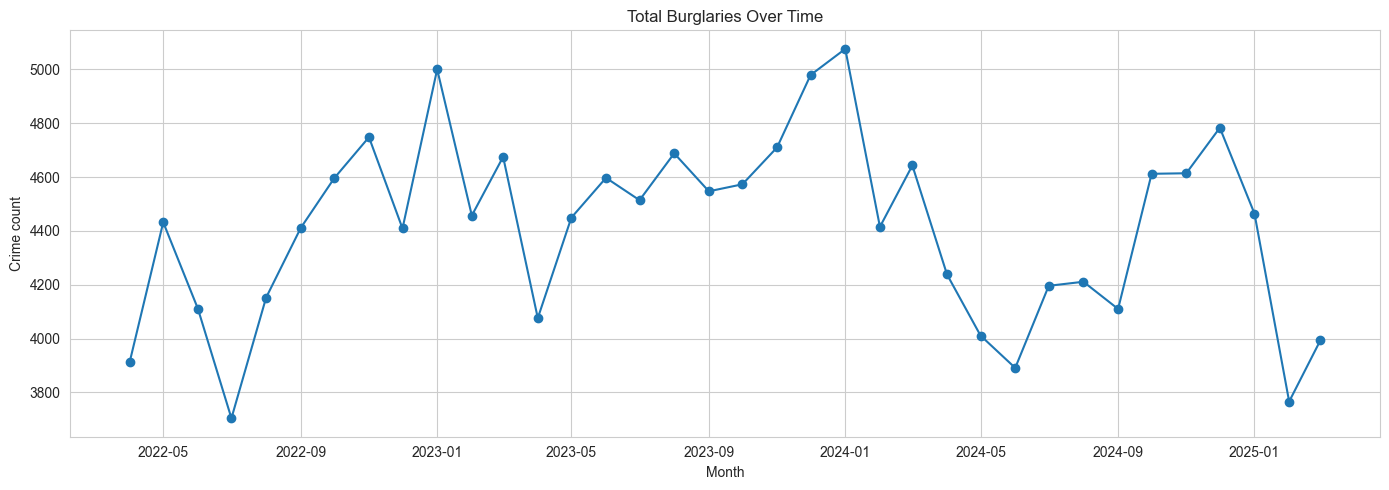

'There seems to be seasonality, although it is rather irregular. Most prominent are the peaks around December/January.'

In [8]:
# TOTAL BURGLARIES OVER TIME

df_burglaries_over_time = df_burglaries.groupby("Month")["Crime count"].sum().reset_index()

# plot
plt.figure(figsize=(14, 5))
plt.plot(df_burglaries_over_time["Month"], df_burglaries_over_time["Crime count"], marker='o')
plt.title("Total Burglaries Over Time")
plt.xlabel("Month")
plt.ylabel("Crime count")
plt.grid(True)
plt.tight_layout()
plt.show()


'There seems to be seasonality, although it is rather irregular. Most prominent are the peaks around December/January.'

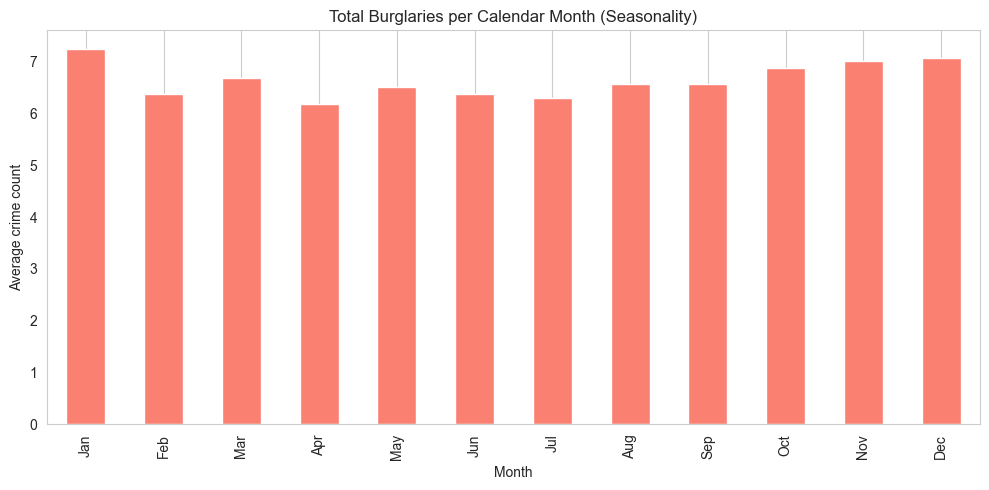

'The differences do not seem too pronounced, but generally colder months in autumn/winter such as November, December, January show higher crime counts compared to months in the summer such as June and July.'

In [9]:
# CRIMES BY MONTH OF YEAR

# Extract month name or number
df_burglaries["Month_num"] = df_burglaries["Month"].dt.month
df_burglaries["Month_name"] = df_burglaries["Month"].dt.strftime('%b')

# Average crime per calendar month
df_seasonality = (
    df_burglaries.groupby("Month_name")["Crime count"]
    .mean()
    .reindex(["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
)

# Plot
plt.figure(figsize=(10, 5))
df_seasonality.plot(kind="bar", color="salmon")
plt.title("Total Burglaries per Calendar Month (Seasonality)")
plt.ylabel("Average crime count")
plt.xlabel("Month")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


'The differences do not seem too pronounced, but generally colder months in autumn/winter such as November, December, January show higher crime counts compared to months in the summer such as June and July.'


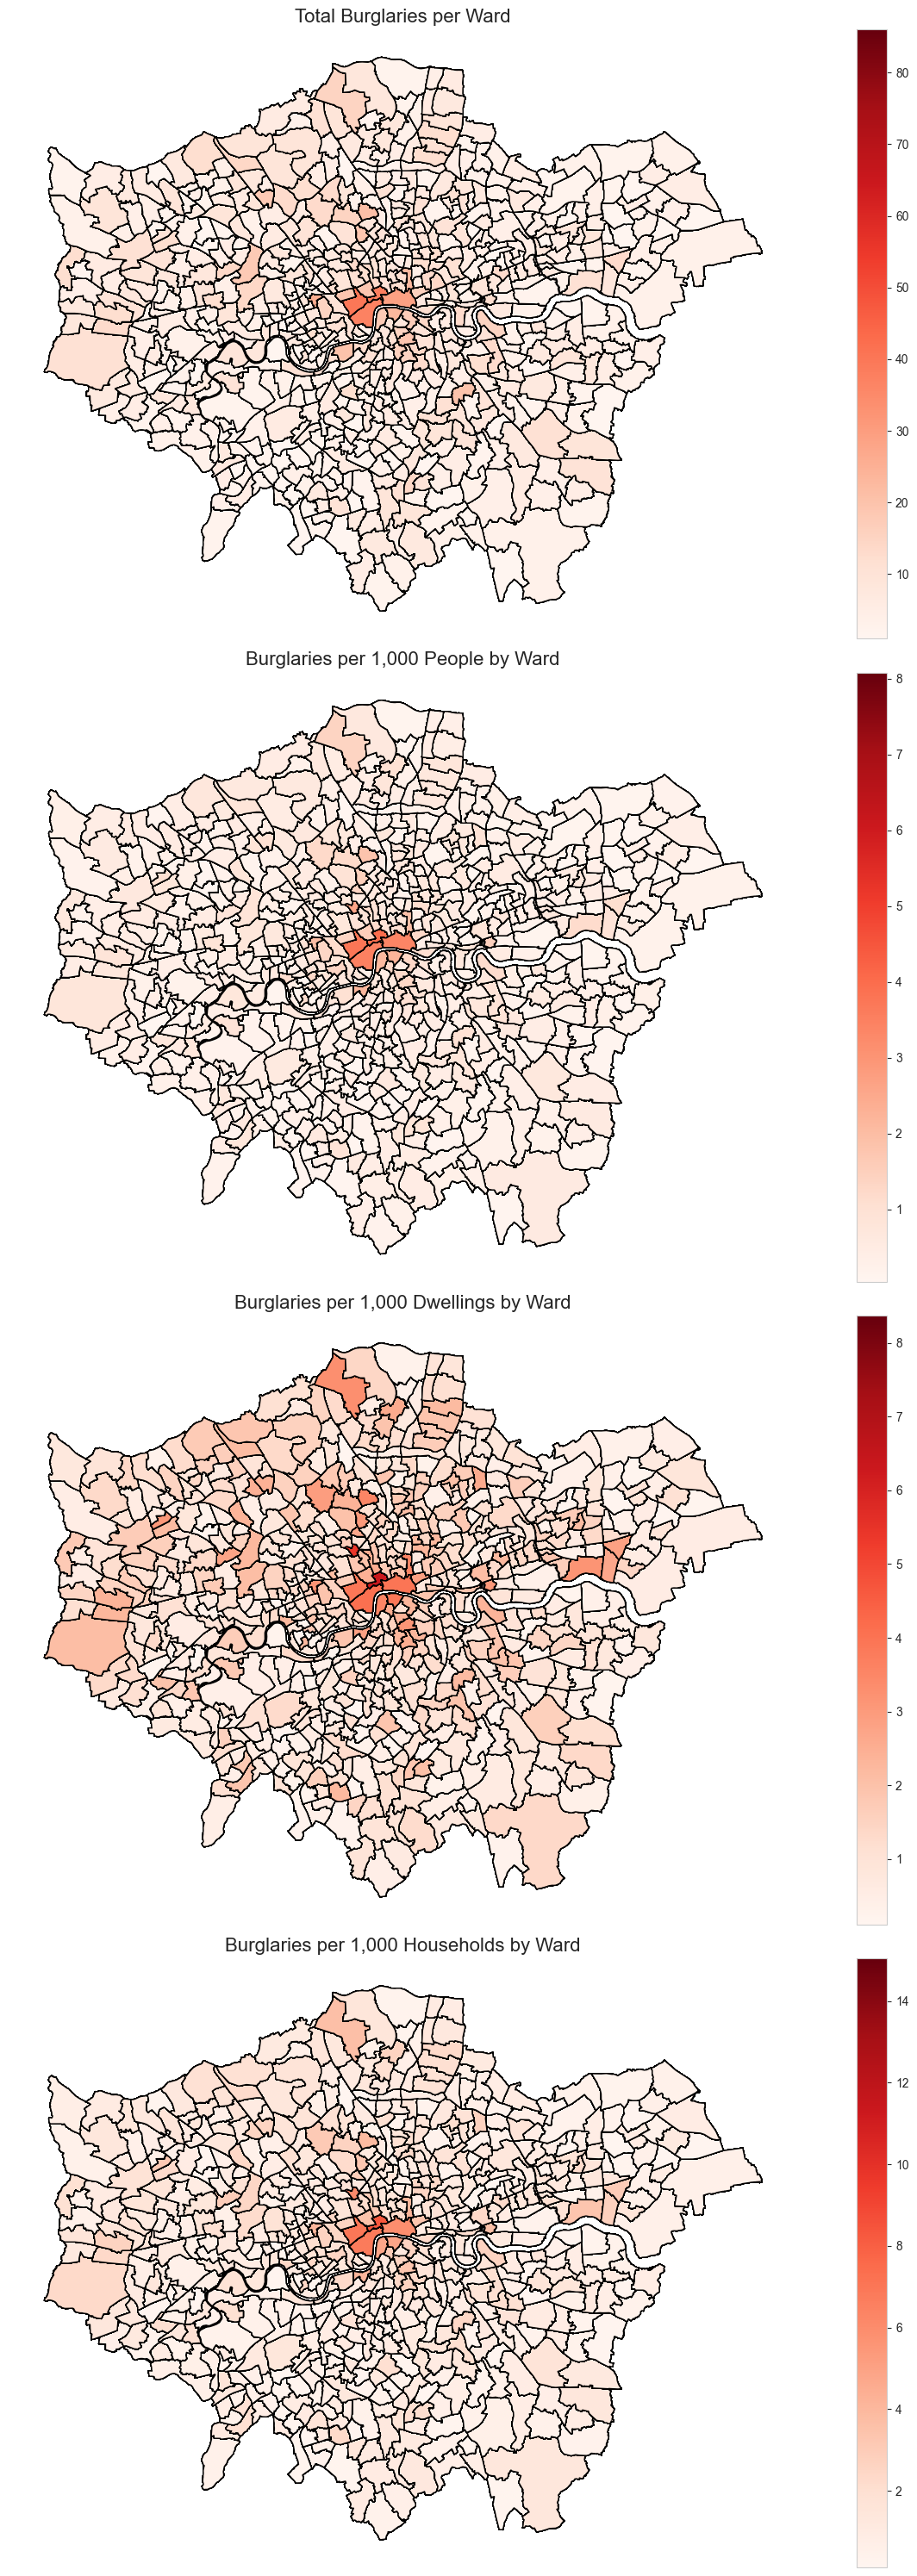

'There is minimal difference when normalizing by total population or the number of households, the biggest difference is observed for the number of dwellings. I suggest normalizing by the number of dwellings or by the number of households, as burglaries are often targeted at dwellings/households, but we can choose any one of these 4.'

In [10]:
# (NORMALIZED) CRIME RATES PER WARD 

# Merge with GeoDataFrame
gdf_crime_rates = gdf_ward_boundaries.merge(df_ward_features, left_on='WD24CD', right_on="Ward code", how="left")

# Create figure and axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))

# Plot 1: Total Crimes
gdf_crime_rates.plot(
    column="Crime count", ax=axes[0], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[0].set_title("Total Burglaries per Ward", fontsize=16)
axes[0].axis("off")

# Plot 2: Crimes per 1,000 People
gdf_crime_rates.plot(
    column="Crimes per 1,000 people", ax=axes[1], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[1].set_title("Burglaries per 1,000 People by Ward", fontsize=16)
axes[1].axis("off")

# Plot 3: Crimes per 1,000 dwellings
gdf_crime_rates.plot(
    column="Crimes per 1,000 dwellings", ax=axes[2], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[2].set_title("Burglaries per 1,000 Dwellings by Ward", fontsize=16)
axes[2].axis("off")

# Plot 4: Crimes per 1,000 households
gdf_crime_rates.plot(
    column="Crimes per 1,000 households", ax=axes[3], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[3].set_title("Burglaries per 1,000 Households by Ward", fontsize=16)
axes[3].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

'There is minimal difference when normalizing by total population or the number of households, the biggest difference is observed for the number of dwellings. I suggest normalizing by the number of dwellings or by the number of households, as burglaries are often targeted at dwellings/households, but we can choose any one of these 4.'

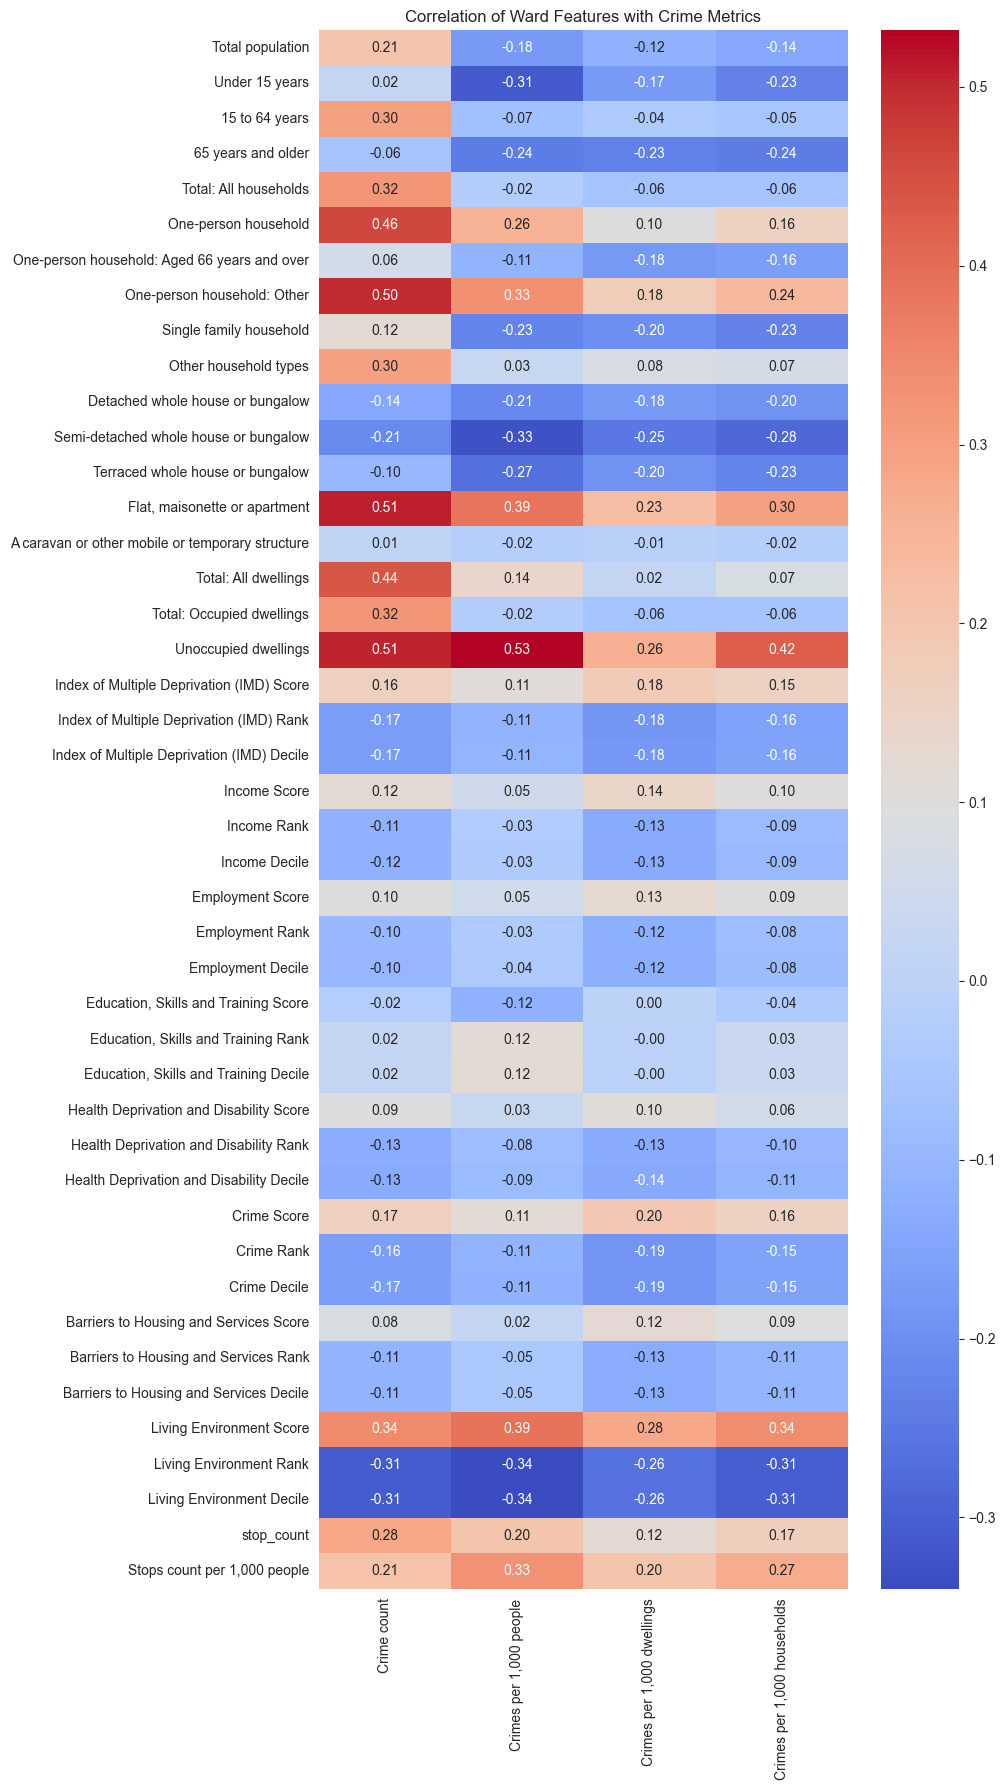

In [11]:
# CORRELATION MATRIX

# Select only numeric columns
numeric_data = df_ward_features.select_dtypes(include="number")

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Focus only on correlations with crime metrics
target_vars = ["Crime count", "Crimes per 1,000 people", "Crimes per 1,000 dwellings", "Crimes per 1,000 households"]
crime_corr = corr_matrix[target_vars].drop(index=target_vars)

# Plot heatmap
plt.figure(figsize=(10, 18))
sns.heatmap(crime_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation of Ward Features with Crime Metrics")
plt.tight_layout()
plt.show()


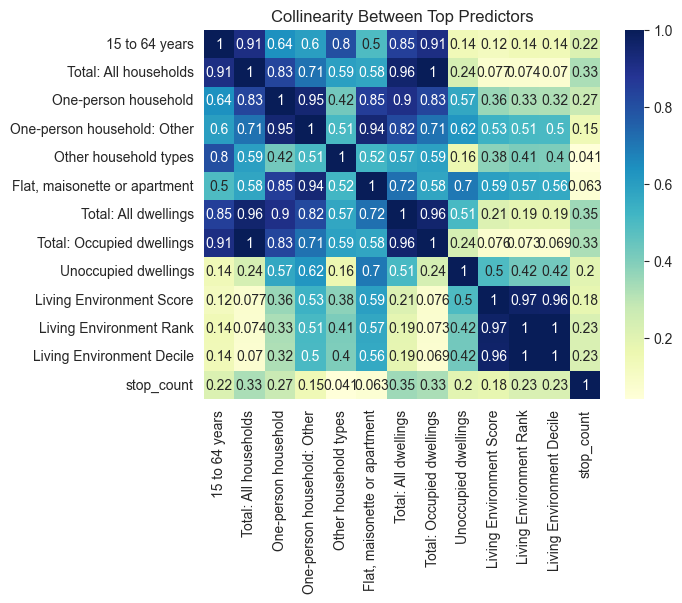

In [56]:
# CORRELATION BETWEEN MOST PROMISING PREDICTORS

# Compute correlation between predictors only
feature_corr = numeric_data.drop(columns=target_vars).corr().abs()

# Mask self-correlations
upper = feature_corr.where(np.triu(np.ones(feature_corr.shape), k=1).astype(bool))

# Find pairs with high collinearity
high_corr_pairs = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > 0.85]

# 1. Filter by correlation with crime (e.g., abs(corr) > 0.3)
target = "Crime count"  
top_feats = crime_corr[abs(crime_corr[target]) > 0.25].index.tolist()

# 2. Check collinearity among top features
corr_subset = df_ward_features[top_feats].corr().abs()

# 3. Drop redundant features (manually or programmatically)
sns.heatmap(corr_subset, annot=True, cmap='YlGnBu')
plt.title("Collinearity Between Top Predictors")
plt.show()



Plan is to first keep all features, then use SHAP or XGBoost.feature_importance to prune later, ensuring interpretability. However, the most obvious collinear pairs will be removed: for indices of deprivation metrics, keep only the score and not rank/decile. 

**EXPLORATION FEATURE ENGINEERING** 

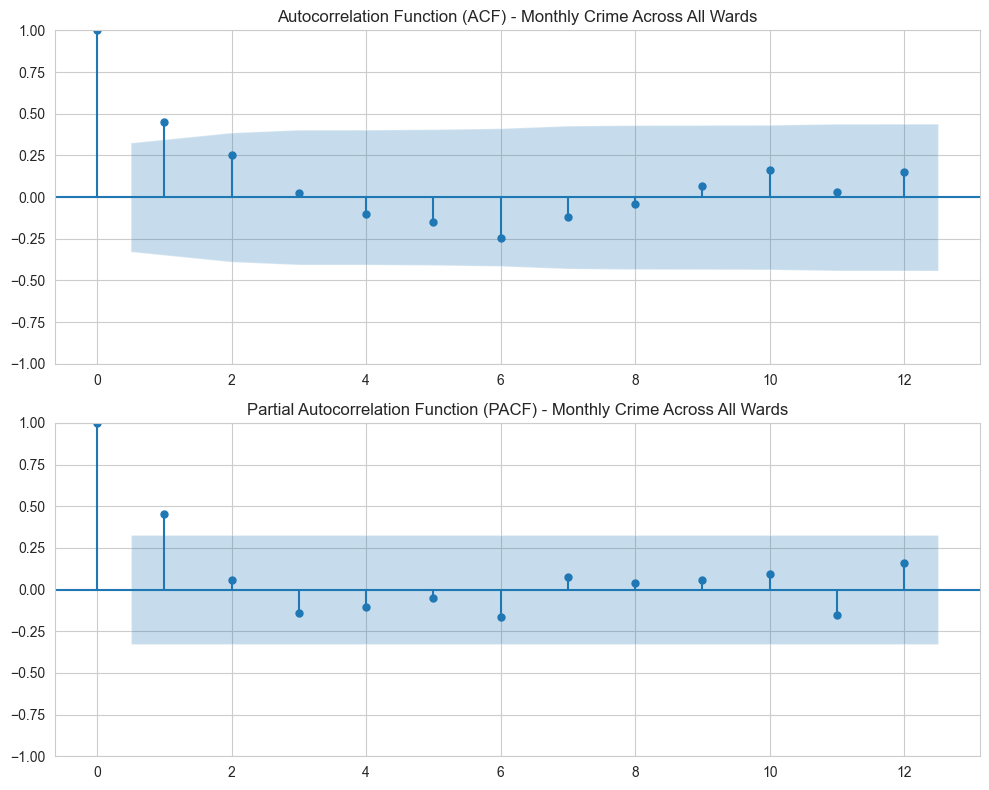

'Only the first lag appears significant to include in the model. However, I can try to experiment with up to lag 6. I do not think we should go beyond that, because of little data.'

In [42]:
# VISUALIZE LAGS

# aggregate globally (sum over wards for each year-month)
burglaries_ts = df_burglaries.groupby("Month")["Crime count"].sum().sort_index()

# ACF and PACF for global monthly series
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(burglaries_ts, lags=12, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF) - Monthly Crime Across All Wards")

plot_pacf(burglaries_ts, lags=12, ax=ax[1], method="ywm")
ax[1].set_title("Partial Autocorrelation Function (PACF) - Monthly Crime Across All Wards")

plt.tight_layout()
plt.show()

'Only the first lag appears significant to include in the model. However, I can try to experiment with up to lag 6. I do not think we should go beyond that, because of little data.'


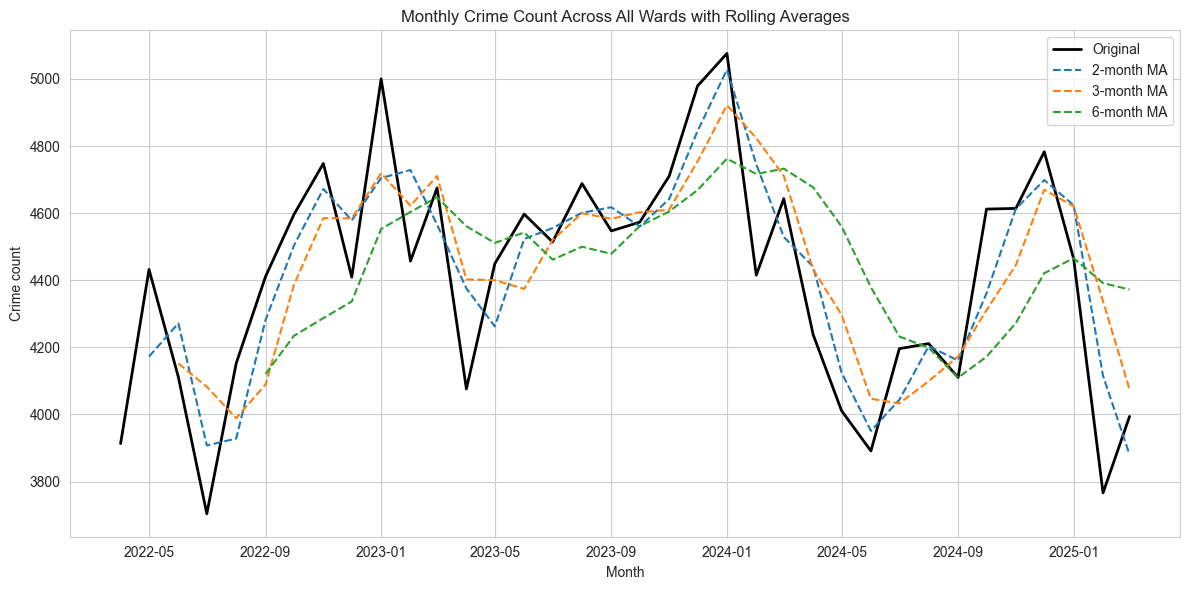

'We already do not have a lot of data, so we should not have a large window for moving average (if we include it at all). I think I can maybe try with moving average up to 6 for now.'

In [43]:
# VISUALIZE ROLLING AVERAGES

# Rolling averages
rolling_2 = burglaries_ts.rolling(window=2).mean()
rolling_3 = burglaries_ts.rolling(window=3).mean()
rolling_6 = burglaries_ts.rolling(window=6).mean()

# Plot all
plt.figure(figsize=(12, 6))
plt.plot(burglaries_ts, label="Original", color="black", linewidth=2)
plt.plot(rolling_2, label="2-month MA", linestyle="--")
plt.plot(rolling_3, label="3-month MA", linestyle="--")
plt.plot(rolling_6, label="6-month MA", linestyle="--")

plt.title("Monthly Crime Count Across All Wards with Rolling Averages")
plt.xlabel("Month")
plt.ylabel("Crime count")
plt.legend()
plt.tight_layout()
plt.show()

'We already do not have a lot of data, so we should not have a large window for moving average (if we include it at all). I think I can maybe try with moving average up to 6 for now.'


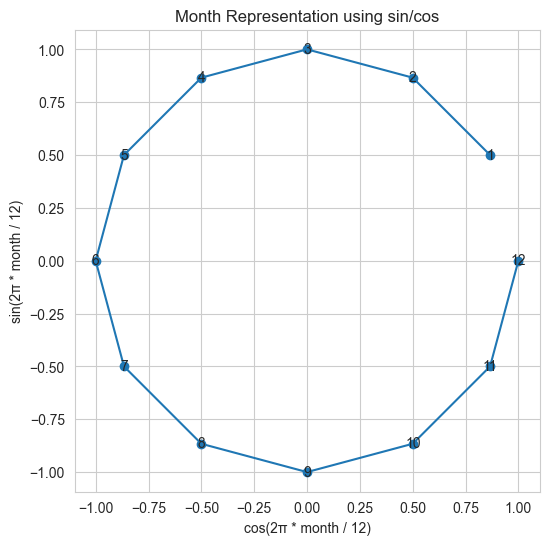

'I will experiment using month sin/cos for a more cyclical interpretation and separate dummies for each month.'

In [44]:
# MONTH REPRESENTATION USING SIN/COS. ALTERNATIVE IS TO ENCODE EACH MONTH AS CATEGORICAL (which I will also experiment with, and see which has higher performance. 
months = np.arange(1, 13)
month_sin = np.sin(2 * np.pi * months / 12)
month_cos = np.cos(2 * np.pi * months / 12)

plt.figure(figsize=(6, 6))
plt.plot(month_cos, month_sin, marker='o')
for i, m in enumerate(months, 1):
    plt.text(month_cos[i-1], month_sin[i-1], str(m), ha='center', va='center')
plt.title("Month Representation using sin/cos")
plt.xlabel("cos(2π * month / 12)")
plt.ylabel("sin(2π * month / 12)")
plt.grid(True)
plt.axis("equal")
plt.show()

'I will experiment using month sin/cos for a more cyclical interpretation and separate dummies for each month.'


In [45]:
# CHECK STATIONARITY: WHETHER TO DIFFERENCE

# Apply Augmented Dickey-Fuller test
adf_result = adfuller(burglaries_ts)

# Display results
print("ADF Statistic:", round(adf_result[0], 4))
print("p-value:", round(adf_result[1], 4))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {round(value, 4)}")

if adf_result[1] < 0.05:
    print("\nThe time series is likely stationary (p < 0.05).")
else:
    print("\nThe time series is likely non-stationary (p ≥ 0.05).")
    
'Based on this, I do not think including first difference is necessary.'


ADF Statistic: -3.4928
p-value: 0.0082
Critical Value (1%): -3.6327
Critical Value (5%): -2.9485
Critical Value (10%): -2.613

The time series is likely stationary (p < 0.05).


'Based on this, I do not think including first difference is necessary.'

**MODEL SETUP**

As of now, the model set-up and evaluation is for next-month prediction only. Perhaps later, I will evaluate forecasting multiple months into the future and do further fine-tuning etc. 

In [13]:
def create_temporal_features(df, lags=[1], rolling_window=None, month_encoding="sin_cos"):
    df = df.copy()
    df["Month"] = pd.to_datetime(df["Month"])
    df.sort_values(["Ward code", "Month"], inplace=True)
    df["month_num"] = df["Month"].dt.month

    # Month encoding
    if month_encoding == "sin_cos":
        df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
        df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)
        df.drop(columns=["month_num"], inplace=True)
    elif month_encoding == "one_hot":
        dummies = pd.get_dummies(df["month_num"], prefix="month")
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=["month_num"], inplace=True)

    # Lag features
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby("Ward code")["Crime count"].shift(lag)

    # Rolling average
    if rolling_window:
        df[f"rolling_mean_{rolling_window}"] = (
            df.groupby("Ward code")["Crime count"]
            .shift(1)
            .rolling(rolling_window)
            .mean()
        )
    
    # Ward code as category
    df["Ward code"] = df["Ward code"].astype("category")


    df.dropna(inplace=True)
    return df


In [14]:
def temporal_train_test_split(df, test_months=6):
    months = df["Month"].sort_values().unique()
    split_point = months[-test_months]
    train_df = df[df["Month"] < split_point]
    test_df = df[df["Month"] >= split_point]
    return train_df, test_df


In [15]:
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

def train_and_evaluate(train_df, test_df, features):
    X_train = train_df[features]
    y_train = train_df["Crime count"]
    X_test = test_df[features]
    y_test = test_df["Crime count"]

    model = xgb.XGBRegressor(enable_categorical=True, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, preds)
    return rmse, model


In [19]:
# GENERATE DIFFERENT CONFIGURATIONS

# Generate all non-empty combinations of lags from 1 to 6
lag_pool = [1, 2, 3, 4, 5, 6]
lag_options = [list(comb) for r in range(1, len(lag_pool)+1) for comb in itertools.combinations(lag_pool, r)]

# Other experiment parameters
rolling_options = [None, 2, 3, 4, 5, 6]
month_encodings = ["sin_cos", "one_hot"]

# Cartesian product of all configurations
experiment_configs = list(itertools.product(lag_options, rolling_options, month_encodings))


**BASELINE MODEL: GLOBAL XGBOOST WITH ONLY BURGLARY TIME SERIES**

In [21]:
results_burglaries = []

for i, (lags, rolling, month_encoding) in enumerate(experiment_configs):
    print(f"\n[Baseline {i+1}/{len(experiment_configs)}] Lags: {lags}, Rolling: {rolling}, Month Encoding: {month_encoding}")
    
    features_df_burglaries = create_temporal_features(df_burglaries, lags=lags, rolling_window=rolling, month_encoding=month_encoding)
    feature_cols_burglaries = [col for col in features_df_burglaries.columns if col.startswith(("lag_", "rolling", "month_"))] + ["Ward code"]

    train_df_burglaries, test_df_burglaries = temporal_train_test_split(features_df_burglaries, test_months=4)
    rmse, model = train_and_evaluate(train_df_burglaries, test_df_burglaries, feature_cols_burglaries)

    results_burglaries.append({
        "Experiment": i + 1,
        "Lags": lags,
        "Rolling": rolling,
        "Month Encoding": month_encoding,
        "RMSE": rmse
    })
    print(f"RMSE: {rmse:.2f}")



[Baseline 1/756] Lags: [1], Rolling: None, Month Encoding: sin_cos
RMSE: 3.92

[Baseline 2/756] Lags: [1], Rolling: None, Month Encoding: one_hot
RMSE: 3.93

[Baseline 3/756] Lags: [1], Rolling: 2, Month Encoding: sin_cos
RMSE: 3.88

[Baseline 4/756] Lags: [1], Rolling: 2, Month Encoding: one_hot
RMSE: 3.87

[Baseline 5/756] Lags: [1], Rolling: 3, Month Encoding: sin_cos
RMSE: 3.89

[Baseline 6/756] Lags: [1], Rolling: 3, Month Encoding: one_hot
RMSE: 3.90

[Baseline 7/756] Lags: [1], Rolling: 4, Month Encoding: sin_cos
RMSE: 3.88

[Baseline 8/756] Lags: [1], Rolling: 4, Month Encoding: one_hot
RMSE: 3.95

[Baseline 9/756] Lags: [1], Rolling: 5, Month Encoding: sin_cos
RMSE: 3.93

[Baseline 10/756] Lags: [1], Rolling: 5, Month Encoding: one_hot
RMSE: 3.89

[Baseline 11/756] Lags: [1], Rolling: 6, Month Encoding: sin_cos
RMSE: 3.92

[Baseline 12/756] Lags: [1], Rolling: 6, Month Encoding: one_hot
RMSE: 3.90

[Baseline 13/756] Lags: [2], Rolling: None, Month Encoding: sin_cos
RMSE: 4.01

In [22]:
results_df_burglaries = pd.DataFrame(results_burglaries)
results_df_burglaries = results_df_burglaries.sort_values("RMSE", na_position="last").reset_index(drop=True)
display(results_df_burglaries)


,Experiment,Lags,Rolling,Month Encoding,RMSE
0,583,"[1, 3, 4, 6]",4.0,sin_cos,3.765236
1,565,"[1, 3, 4, 5]",NaN,sin_cos,3.782759
2,727,"[1, 3, 4, 5, 6]",4.0,sin_cos,3.784055
3,314,"[1, 3, 5]",NaN,one_hot,3.790993
4,571,"[1, 3, 4, 5]",4.0,sin_cos,3.796305
...,...,...,...,...,...
751,170,"[2, 6]",NaN,one_hot,4.087010
752,14,[2],NaN,one_hot,4.092443
753,62,[6],NaN,one_hot,4.095408
754,146,"[2, 4]",NaN,one_hot,4.103843


In [23]:
best_burglaries_config = results_df_burglaries.iloc[0]
print("Best Config (Baseline):\n", best_burglaries_config)

lags_best = best_burglaries_config["Lags"]
rolling_best = None if pd.isna(best_burglaries_config["Rolling"]) else int(best_burglaries_config["Rolling"])
month_encoding_best = best_burglaries_config["Month Encoding"]

features_df_burglaries = create_temporal_features(df_burglaries, lags=lags_best, rolling_window=rolling_best, month_encoding=month_encoding_best)
feature_cols_burglaries = [col for col in features_df_burglaries.columns if col.startswith(("lag_", "rolling", "month_"))] + ["Ward code"]

train_df_burglaries, test_df_burglaries = temporal_train_test_split(features_df_burglaries, test_months=4)
rmse, final_model_burglaries = train_and_evaluate(train_df_burglaries, test_df_burglaries, feature_cols_burglaries)


Best Config (Baseline):
 Experiment                 583
Lags              [1, 3, 4, 6]
Rolling                    4.0
Month Encoding         sin_cos
RMSE                  3.765236
Name: 0, dtype: object


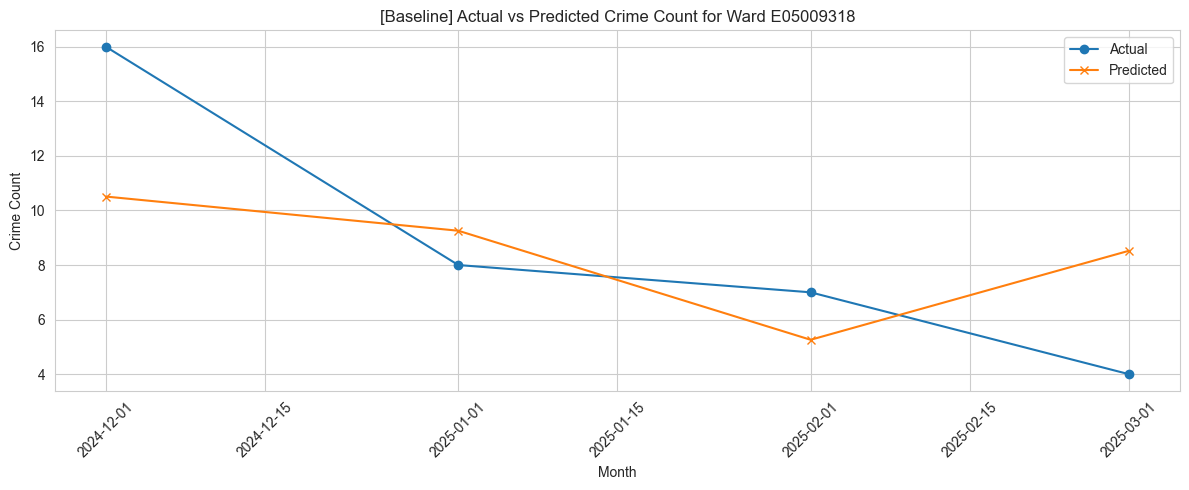

In [24]:
test_df_burglaries = test_df_burglaries.copy()
test_df_burglaries["prediction"] = final_model_burglaries.predict(test_df_burglaries[feature_cols_burglaries])

ward_to_plot = test_df_burglaries["Ward code"].unique()[1]
ward_df = test_df_burglaries[test_df_burglaries["Ward code"] == ward_to_plot].sort_values("Month")

plt.figure(figsize=(12, 5))
plt.plot(ward_df["Month"], ward_df["Crime count"], label="Actual", marker='o')
plt.plot(ward_df["Month"], ward_df["prediction"], label="Predicted", marker='x')
plt.title(f"[Baseline] Actual vs Predicted Crime Count for Ward {ward_to_plot}")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


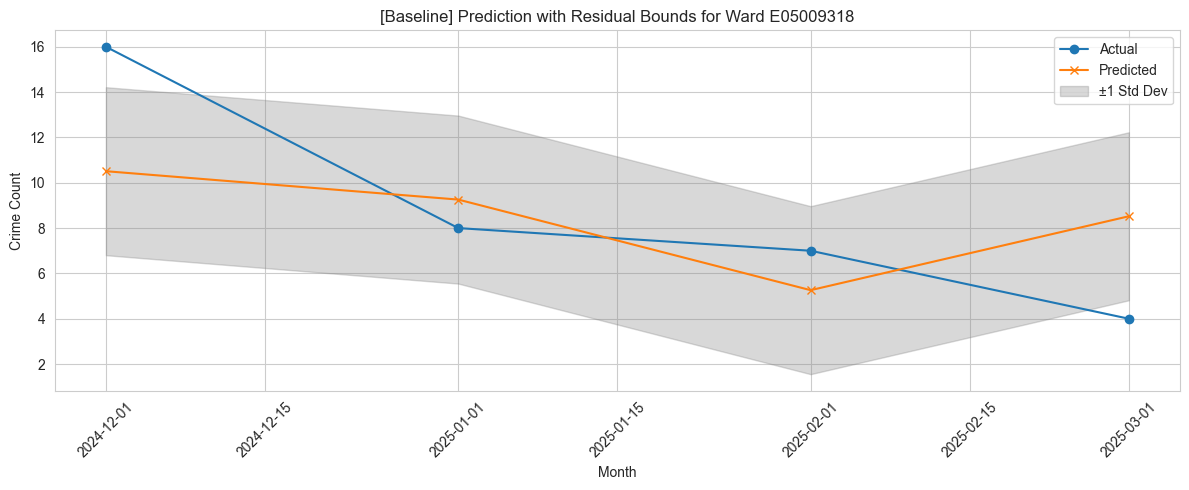

In [25]:
residuals = test_df_burglaries["Crime count"] - test_df_burglaries["prediction"]
std_resid = np.std(residuals)

plt.figure(figsize=(12, 5))
plt.plot(ward_df["Month"], ward_df["Crime count"], label="Actual", marker='o')
plt.plot(ward_df["Month"], ward_df["prediction"], label="Predicted", marker='x')
plt.fill_between(ward_df["Month"], ward_df["prediction"] - std_resid, ward_df["prediction"] + std_resid,
                 color='gray', alpha=0.3, label="±1 Std Dev")
plt.title(f"[Baseline] Prediction with Residual Bounds for Ward {ward_to_plot}")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**ADVANCED MODEL: GLOBAL XGBOOST WITH ADDITIONAL STATIC FEATURES**

In [60]:
# INCLUDE STATIC FEATURES
df_deprivation_filtered = df_deprivation.loc[:, df_deprivation.columns.str.contains('Score|Ward code')]
static_features_df = df_census.merge(df_deprivation_filtered, on="Ward code").merge(df_stops[["Ward code", "stop_count"]], on="Ward code", how="left")
df_all_features = df_burglaries.merge(static_features_df, on="Ward code")

print(static_features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Ward code                                         680 non-null    object 
 1   Total population                                  680 non-null    int64  
 2   Under 15 years                                    680 non-null    int64  
 3   15 to 64 years                                    680 non-null    int64  
 4   65 years and older                                680 non-null    int64  
 5   Total: All households                             680 non-null    float64
 6   One-person household                              680 non-null    float64
 7   One-person household: Aged 66 years and over      680 non-null    float64
 8   One-person household: Other                       680 non-null    float64
 9   Single family househo

In [61]:
results_all_features = []

for i, (lags, rolling, month_encoding) in enumerate(experiment_configs):
    print(f"\n[Enhanced {i+1}/{len(experiment_configs)}] Lags: {lags}, Rolling: {rolling}, Month Encoding: {month_encoding}")

    features_df_all = create_temporal_features(df_all_features, lags=lags, rolling_window=rolling, month_encoding=month_encoding)
    feature_cols_all = [col for col in features_df_all.columns if col.startswith(("lag_", "rolling", "month_"))] + list(static_features_df.columns)

    train_df_all, test_df_all = temporal_train_test_split(features_df_all, test_months=4)
    rmse, model = train_and_evaluate(train_df_all, test_df_all, feature_cols_all)

    results_all_features.append({
        "Experiment": i + 1,
        "Lags": lags,
        "Rolling": rolling,
        "Month Encoding": month_encoding,
        "RMSE": rmse
    })
    print(f"RMSE: {rmse:.2f}")



[Enhanced 1/756] Lags: [1], Rolling: None, Month Encoding: sin_cos
RMSE: 3.90

[Enhanced 2/756] Lags: [1], Rolling: None, Month Encoding: one_hot
RMSE: 3.93

[Enhanced 3/756] Lags: [1], Rolling: 2, Month Encoding: sin_cos
RMSE: 3.85

[Enhanced 4/756] Lags: [1], Rolling: 2, Month Encoding: one_hot
RMSE: 3.91

[Enhanced 5/756] Lags: [1], Rolling: 3, Month Encoding: sin_cos
RMSE: 3.82

[Enhanced 6/756] Lags: [1], Rolling: 3, Month Encoding: one_hot
RMSE: 3.94

[Enhanced 7/756] Lags: [1], Rolling: 4, Month Encoding: sin_cos
RMSE: 3.88

[Enhanced 8/756] Lags: [1], Rolling: 4, Month Encoding: one_hot
RMSE: 3.91

[Enhanced 9/756] Lags: [1], Rolling: 5, Month Encoding: sin_cos
RMSE: 3.87

[Enhanced 10/756] Lags: [1], Rolling: 5, Month Encoding: one_hot
RMSE: 3.90

[Enhanced 11/756] Lags: [1], Rolling: 6, Month Encoding: sin_cos
RMSE: 3.95

[Enhanced 12/756] Lags: [1], Rolling: 6, Month Encoding: one_hot
RMSE: 3.98

[Enhanced 13/756] Lags: [2], Rolling: None, Month Encoding: sin_cos
RMSE: 4.02

In [62]:
results_df_all_features = pd.DataFrame(results_all_features)
results_df_all_features = results_df_all_features.sort_values("RMSE", na_position="last").reset_index(drop=True)
display(results_df_all_features)

,Experiment,Lags,Rolling,Month Encoding,RMSE
0,727,"[1, 3, 4, 5, 6]",4.0,sin_cos,3.746802
1,751,"[1, 2, 3, 4, 5, 6]",4.0,sin_cos,3.783382
2,319,"[1, 3, 5]",4.0,sin_cos,3.786832
3,566,"[1, 3, 4, 5]",NaN,one_hot,3.798345
4,607,"[1, 4, 5, 6]",4.0,sin_cos,3.798349
...,...,...,...,...,...
751,170,"[2, 6]",NaN,one_hot,4.075376
752,61,[6],NaN,sin_cos,4.075449
753,26,[3],NaN,one_hot,4.078249
754,432,"[2, 4, 6]",6.0,one_hot,4.080793


In [68]:
best_all_config = results_df_all_features.iloc[0]
print("Best Config (Enhanced):\n", best_all_config)

lags_best = best_all_config["Lags"]
rolling_best = None if pd.isna(best_all_config["Rolling"]) else int(best_all_config["Rolling"])
month_encoding_best = best_all_config["Month Encoding"]

features_df_all = create_temporal_features(df_all_features, lags=lags_best, rolling_window=rolling_best, month_encoding=month_encoding_best)
feature_cols_all = [col for col in features_df_all.columns if col.startswith(("lag_", "rolling", "month_"))] + list(static_features_df.columns)

train_df_all, test_df_all = temporal_train_test_split(features_df_all, test_months=4)
rmse, final_model_all = train_and_evaluate(train_df_all, test_df_all, feature_cols_all)


Best Config (Enhanced):
 Experiment                    727
Lags              [1, 3, 4, 5, 6]
Rolling                       4.0
Month Encoding            sin_cos
RMSE                     3.746802
Name: 0, dtype: object


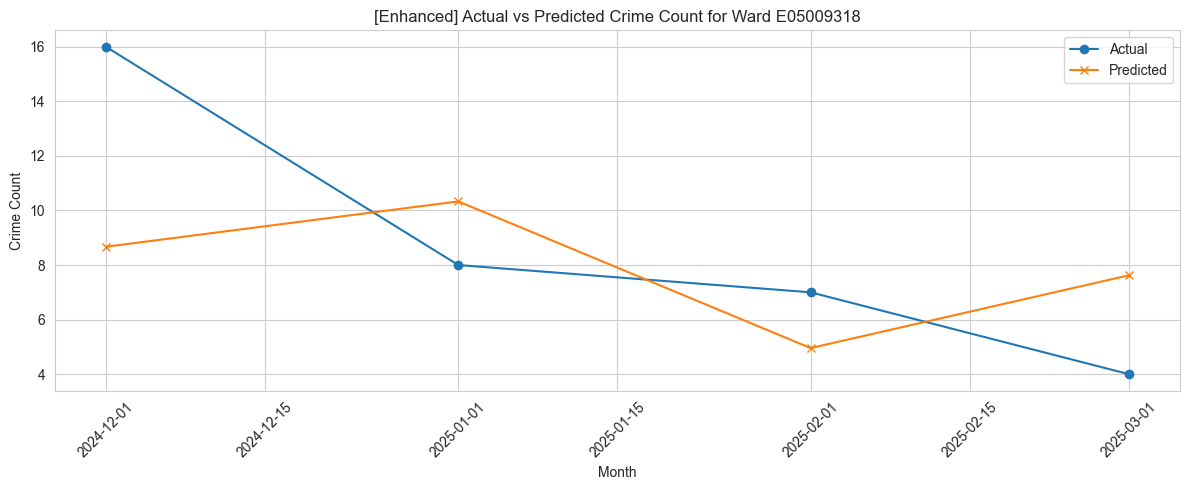

In [69]:
test_df_all = test_df_all.copy()
test_df_all["prediction"] = final_model_all.predict(test_df_all[feature_cols_all])

ward_to_plot = test_df_all["Ward code"].unique()[1]
ward_df_all = test_df_all[test_df_all["Ward code"] == ward_to_plot].sort_values("Month")

plt.figure(figsize=(12, 5))
plt.plot(ward_df_all["Month"], ward_df_all["Crime count"], label="Actual", marker='o')
plt.plot(ward_df_all["Month"], ward_df_all["prediction"], label="Predicted", marker='x')
plt.title(f"[Enhanced] Actual vs Predicted Crime Count for Ward {ward_to_plot}")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**HYPERPARAMETER TUNING FOR BEST MODEL UNTIL NOW**

In [70]:
# the final model on all features performs best. therefore, we perform hyperparameter tuning for that model. Problem is to fid a suitable search space. 

Original Model RMSE: 3.75





Tuning progress: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]

Best Params: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Tuned Model RMSE: 3.93
Improvement: -0.18


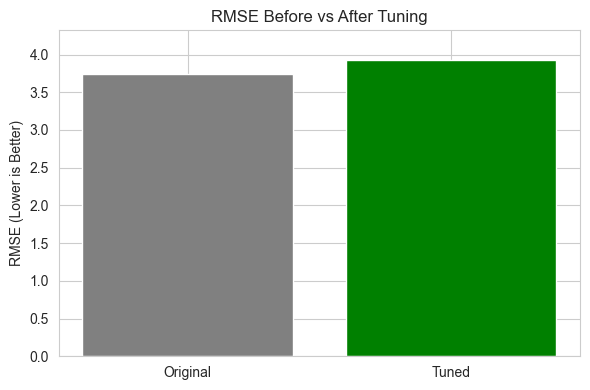

In [82]:
# VERY BASIC TUNING TO SEE IF IT WORKS

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, make_scorer
from xgboost import XGBRegressor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# RMSE scorer using sklearn's built-in function
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Save original model's RMSE
original_preds = final_model_all.predict(test_df_all[feature_cols_all])
original_rmse = root_mean_squared_error(test_df_all["Crime count"], original_preds)
print(f"Original Model RMSE: {original_rmse:.2f}")

# Compact search space
param_dist_small = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Wrap tqdm into RandomizedSearchCV
class TQDMRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, *args, **kwargs):
        self._tqdm = tqdm(total=self.n_iter, desc="Tuning progress")
        super().fit(*args, **kwargs)
        self._tqdm.close()
        return self
    def _run_search(self, evaluate_candidates):
        def wrapped(candidate_params):
            self._tqdm.update(len(candidate_params))
            return evaluate_candidates(candidate_params)
        super()._run_search(wrapped)
        
tscv = TimeSeriesSplit(n_splits=3)

# Run tuning
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)
tuner_small = TQDMRandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist_small,
    n_iter=10,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

tuner_small.fit(train_df_all[feature_cols_all], train_df_all["Crime count"])
print("Best Params:", tuner_small.best_params_)

# Evaluate best model
tuned_preds = tuner_small.best_estimator_.predict(test_df_all[feature_cols_all])
tuned_rmse = root_mean_squared_error(test_df_all["Crime count"], tuned_preds)
print(f"Tuned Model RMSE: {tuned_rmse:.2f}")
print(f"Improvement: {original_rmse - tuned_rmse:.2f}")

# Optional plot
plt.figure(figsize=(6, 4))
plt.bar(["Original", "Tuned"], [original_rmse, tuned_rmse], color=["gray", "green"])
plt.title("RMSE Before vs After Tuning")
plt.ylabel("RMSE (Lower is Better)")
plt.ylim(0, max(original_rmse, tuned_rmse) * 1.1)
plt.tight_layout()
plt.show()


Original Model RMSE: 3.75





Tuning progress: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it]

Best Params (Large Search): {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
Tuned RMSE: 3.56
Improvement: 0.19


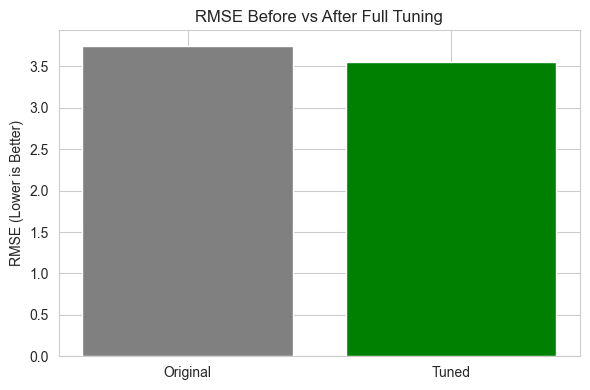

In [83]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, make_scorer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Define scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Save original model RMSE
original_preds = final_model_all.predict(test_df_all[feature_cols_all])
original_rmse = root_mean_squared_error(test_df_all["Crime count"], original_preds)
print(f"Original Model RMSE: {original_rmse:.2f}")

# Large search space
param_dist_large = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0.5, 1.0, 2.0]
}

# Time-aware CV
tscv = TimeSeriesSplit(n_splits=3)

# Tuner with progress bar
class TQDMRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, *args, **kwargs):
        self._tqdm = tqdm(total=self.n_iter, desc="Tuning progress")
        super().fit(*args, **kwargs)
        self._tqdm.close()
        return self
    def _run_search(self, evaluate_candidates):
        def wrapped(candidate_params):
            self._tqdm.update(len(candidate_params))
            return evaluate_candidates(candidate_params)
        super()._run_search(wrapped)

# Run tuning
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)
tuner_large = TQDMRandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist_large,
    n_iter=40,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

tuner_large.fit(train_df_all[feature_cols_all], train_df_all["Crime count"])
print("Best Params (Large Search):", tuner_large.best_params_)

# Evaluate
tuned_preds = tuner_large.best_estimator_.predict(test_df_all[feature_cols_all])
tuned_rmse = root_mean_squared_error(test_df_all["Crime count"], tuned_preds)
print(f"Tuned RMSE: {tuned_rmse:.2f}")
print(f"Improvement: {original_rmse - tuned_rmse:.2f}")

# Visualize
plt.figure(figsize=(6, 4))
plt.bar(["Original", "Tuned"], [original_rmse, tuned_rmse], color=["gray", "green"])
plt.title("RMSE Before vs After Full Tuning")
plt.ylabel("RMSE (Lower is Better)")
plt.tight_layout()
plt.show()


In [87]:
# final tuned model training
best_params = {
    "subsample": 0.6,
    "reg_lambda": 2.0,
    "reg_alpha": 0.1,
    "n_estimators": 100,
    "min_child_weight": 5,
    "max_depth": 10,
    "learning_rate": 0.01,
    "gamma": 0.1,
    "colsample_bytree": 0.6,
    "enable_categorical": True,
    "random_state": 42
}


In [107]:
final_tuned_model = xgb.XGBRegressor(**best_params)

final_tuned_model.fit(train_df_all[feature_cols_all], train_df_all["Crime count"])
test_preds = final_tuned_model.predict(test_df_all[feature_cols_all])

# Evaluate
from sklearn.metrics import mean_squared_error
rmse = root_mean_squared_error(test_df_all["Crime count"], test_preds)
print(f"Final Test RMSE: {rmse:.3f}")


Final Test RMSE: 3.555


**FEATURE IMPORTANCE / SHAP**

<Figure size 1200x800 with 0 Axes>

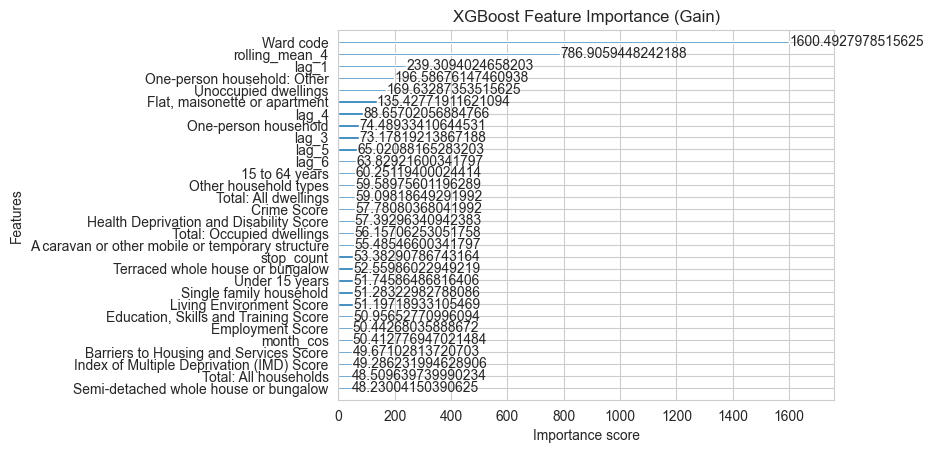

In [99]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot XGBoost feature importance by gain
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_tuned_model, importance_type='gain', max_num_features=30)
plt.title('XGBoost Feature Importance (Gain)')
plt.show()


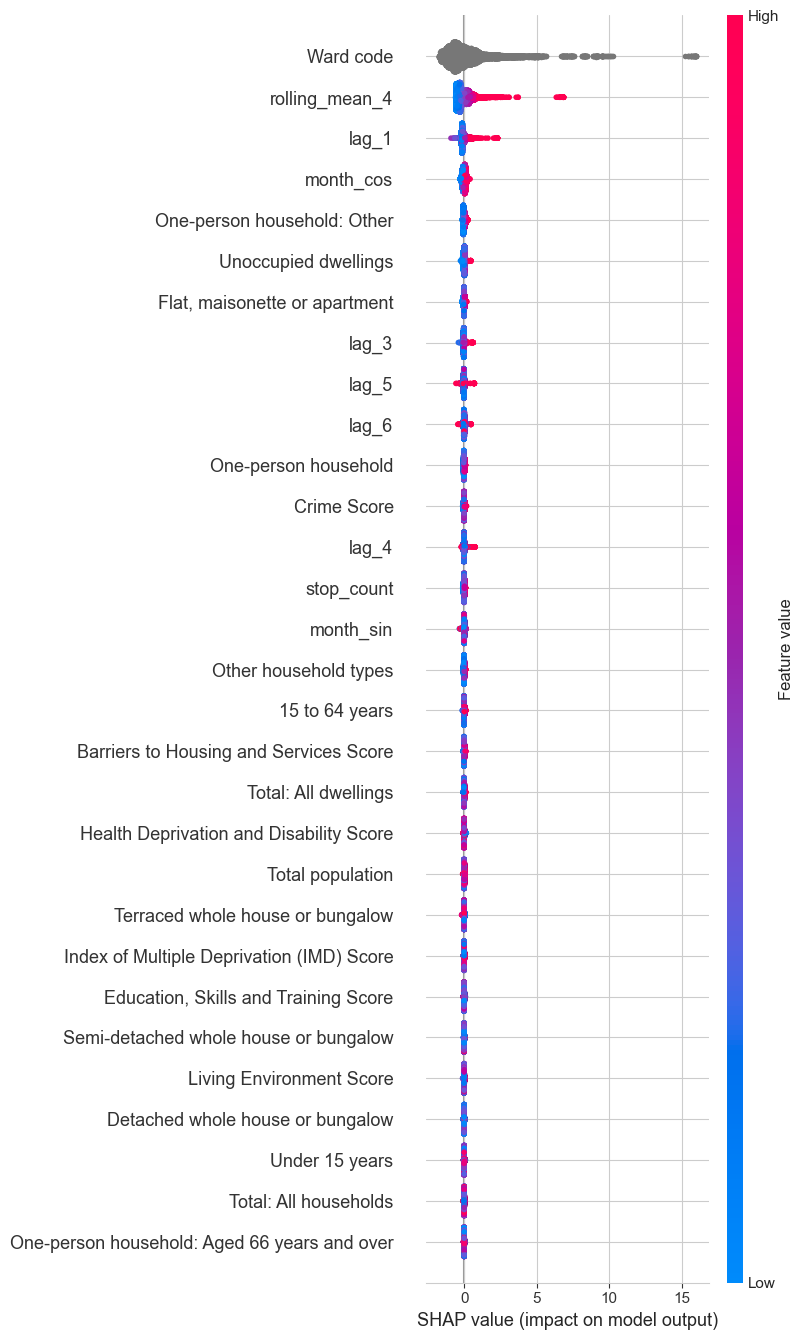

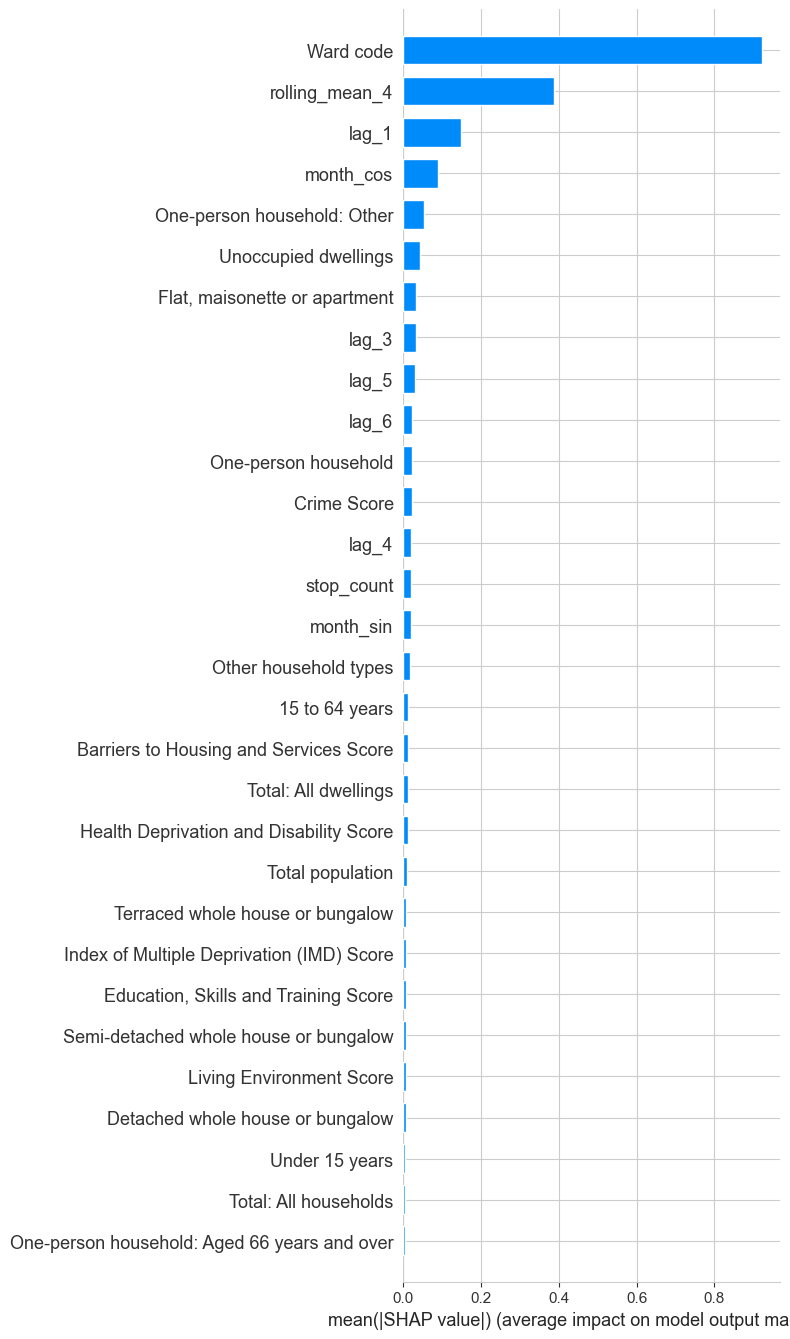

In [104]:
# SHAP
import shap

# Create SHAP explainer and calculate SHAP values for the training data
explainer = shap.Explainer(final_tuned_model)
shap_values = explainer(train_df_all[feature_cols_all])

# Summary dot plot: shows each feature’s impact on the prediction and direction
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, train_df_all[feature_cols_all], plot_type='dot', max_display=30)

# mean absolute impact bar plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, train_df_all[feature_cols_all], plot_type='bar', max_display=30)


In [124]:
# FEATURE PRUNING
def feature_pruning_by_importance(model, feature_names, threshold=0.01):
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type='gain')
    total_gain = sum(importance_dict.values())
    importance_norm = {k: v / total_gain for k, v in importance_dict.items()}
    retained_features = [f for f in feature_names if importance_norm.get(f, 0) >= threshold]
    print(f"Pruned {len(feature_names) - len(retained_features)} features below gain threshold {threshold}")
    return retained_features


print(len(feature_cols_all), 'all features:', feature_cols_all)

pruned_features = feature_pruning_by_importance(final_tuned_model, feature_cols_all, threshold=0.02)
print(len(pruned_features), 'pruned features:', pruned_features)

# Retrain with pruned features and evaluate RMSE
pruned_model = xgb.XGBRegressor(**best_params)

pruned_model.fit(train_df_all[pruned_features], train_df_all["Crime count"])
test_preds = pruned_model.predict(test_df_all[pruned_features])

# Evaluate
from sklearn.metrics import mean_squared_error
rmse = root_mean_squared_error(test_df_all["Crime count"], test_preds)
print(f"\n Final Test RMSE: {rmse:.3f}")


36 all features: ['month_sin', 'month_cos', 'lag_1', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean_4', 'Ward code', 'Total population', 'Under 15 years', '15 to 64 years', '65 years and older', 'Total: All households', 'One-person household', 'One-person household: Aged 66 years and over', 'One-person household: Other', 'Single family household', 'Other household types', 'Detached whole house or bungalow', 'Semi-detached whole house or bungalow', 'Terraced whole house or bungalow', 'Flat, maisonette or apartment', 'A caravan or other mobile or temporary structure', 'Total: All dwellings', 'Total: Occupied dwellings', 'Unoccupied dwellings', 'Index of Multiple Deprivation (IMD) Score', 'Income Score', 'Employment Score', 'Education, Skills and Training Score', 'Health Deprivation and Disability Score', 'Crime Score', 'Barriers to Housing and Services Score', 'Living Environment Score', 'stop_count']
Pruned 30 features below gain threshold 0.02
6 pruned features: ['lag_1', 'rolling_m

In [ ]:
# TODO: maybe more for rolling
# TODO: evaluation of longer term forecasting
# TODO: look into saving model and deployment
# TODO: write it pretty in SSA

**EVALUATION OF LONGER TERM FORECASTING**